In [2]:
import os
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

# default theme
sns.set(context='notebook',style='darkgrid',palette='deep',font='sans-serif',font_scale=1,color_codes=False,rc=None)

# warning handle
warnings.filterwarnings('ignore')

In [12]:
# set train ans test file path
tr_path=''
te_path=''

for dirname, _, filenames in os.walk('../dataset/'):
    for filename in filenames:
        cur_path=os.path.join(dirname,filename)
        print(cur_path)
        if filename.find('train')==0:
            tr_path=cur_path
        elif filename.find('test')==0:
            te_path=cur_path
            
print(f'training file: {tr_path}')
print(f'testing file: {te_path}')

../dataset/train.csv
../dataset/test.csv
training file: ../dataset/train.csv
testing file: ../dataset/test.csv


## Preprocessing and Data Analysis


In [13]:
tr_df=pd.read_csv(tr_path)
tr_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [14]:
te_df=pd.read_csv(te_path)
te_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [15]:
print(f'training set size[{tr_df.shape}]')
print(f'testing set size[{te_df.shape}]')

training set size[(614, 13)]
testing set size[(367, 12)]


**the Preprocessing of the training dataset**

In [19]:
tr_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [20]:
# summary statistics
tr_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [24]:
# the Id column is useless, drop it
if 'Loan_ID' in tr_df.columns:
    tr_df.drop('Loan_ID',axis=1,inplace=True)
if 'Loan_ID' in te_df.columns:
    te_df.drop('Loan_ID',axis=1,inplace=True)
# check the new shapes
print(f'training set[{tr_df.shape}]')
print(f'testing set[{te_df.shape}]')

training set[(614, 12)]
testing set[(367, 11)]


# Missing values
Fill in missing values in dataset

In [28]:
tr_df.isnull().sum().sort_values(ascending=False)

null_cols=tr_df.isnull().any()
# Select only those entries that are True
null_cols=null_cols[null_cols].index.tolist()
print(null_cols)

['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


Replace null value by the most frequent value


In [29]:
# fill in the missing data
print('Before filling missing values\n\n','#'*50,'\n')

for col in null_cols:
    print(f'{col}:\n{tr_df[col].value_counts()}\n','-'*50)
    tr_df[col]=tr_df[col].fillna(tr_df[col].dropna().mode().values[0])
    
tr_df.isnull().sum().sort_values(ascending=False)
print('After filling missing values\n\n','#'*50,'\n')
for col in null_cols:
    print(f'\n{col}:\n{tr_df[col].value_counts()}\n','-'*50)

Before filling missing values

 ################################################## 

Gender:
Gender
Male      489
Female    112
Name: count, dtype: int64
 --------------------------------------------------
Married:
Married
Yes    398
No     213
Name: count, dtype: int64
 --------------------------------------------------
Dependents:
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
 --------------------------------------------------
Self_Employed:
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
 --------------------------------------------------
LoanAmount:
LoanAmount
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: count, Length: 203, dtype: int64
 --------------------------------------------------
Loan_Amount_Term:
Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0     

## Data visualization
1. Split data to categorial and numerical data

## Loan status distribution

In [32]:
# list of all the numeric columns
num = tr_df.select_dtypes('number').columns.to_list()

# list of all the cagetoric columns
cat = tr_df.select_dtypes('object').columns.to_list()

print(f'number[{num}]')
print(f'categories[{cat}]')

# numeric df
loan_num=tr_df[num]
# categoric df
loan_cat=tr_df[cat]

number[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]
categories[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']]


Loan_Status
Y    422
N    192
Name: count, dtype: int64
0      Y
1      N
2      Y
3      Y
4      Y
      ..
609    Y
610    Y
611    Y
612    Y
613    N
Name: Loan_Status, Length: 614, dtype: object


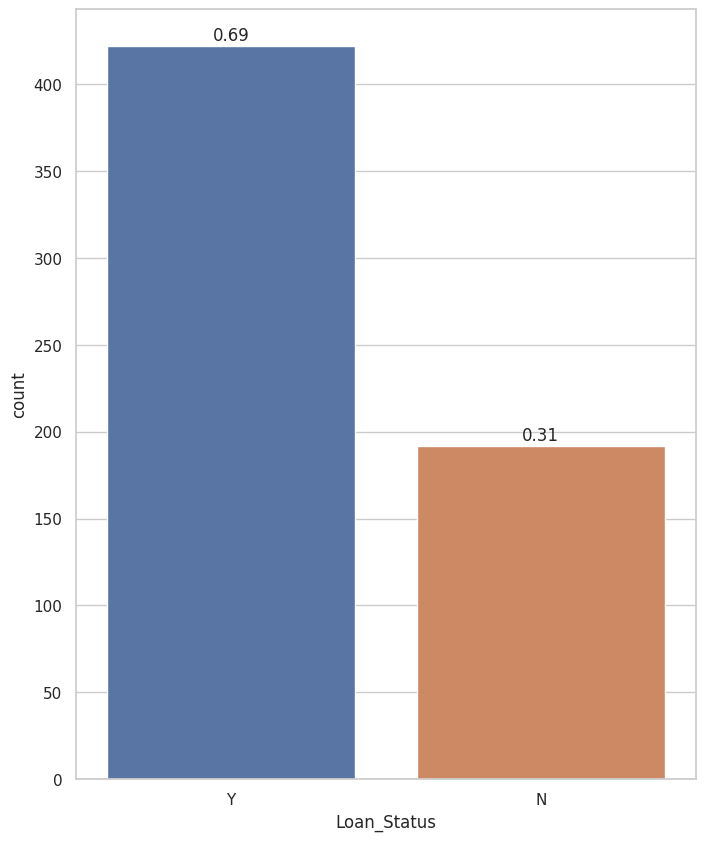

In [35]:
print(tr_df[cat[-1]].value_counts())
print(tr_df[cat[-1]])

total=float(len(tr_df[cat[-1]]))
plt.figure(figsize=(8,10))
sns.set(style='whitegrid')
ax=sns.countplot(data=tr_df,x=cat[-1])
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height+3,'{:1.2f}'.format(height/total),ha='center')
plt.show()

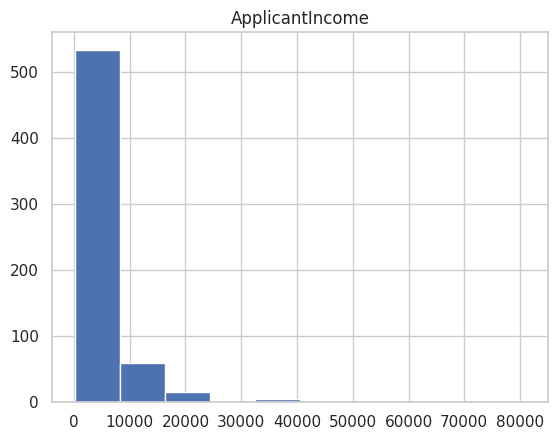

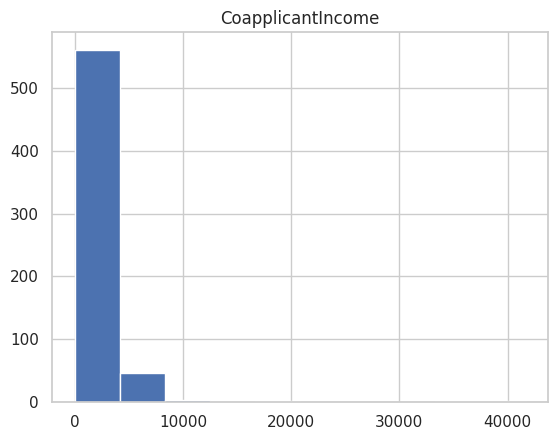

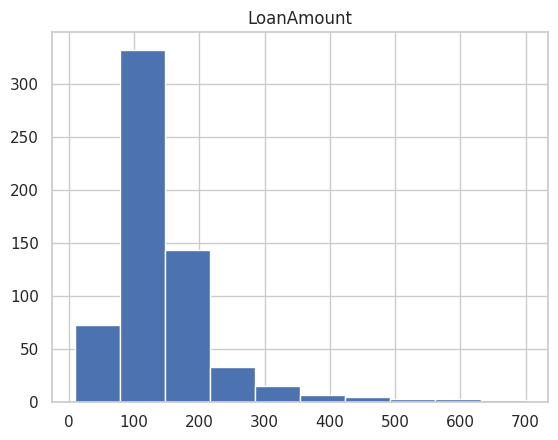

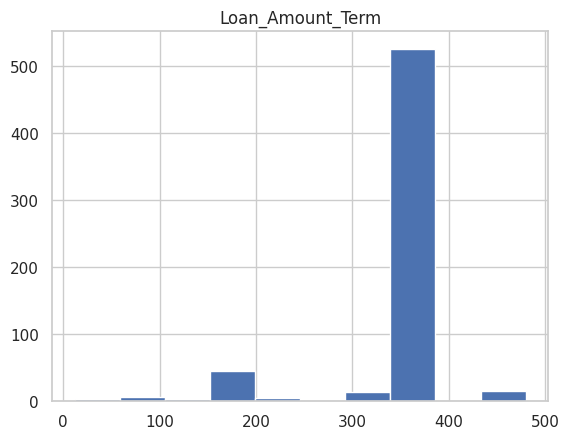

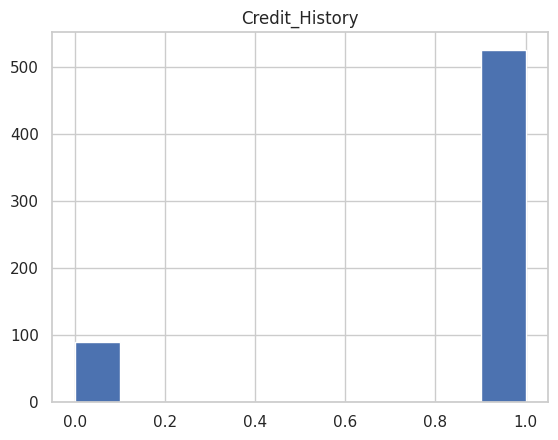

In [37]:
# Plot numeric columns
for i in loan_num:
    plt.hist(loan_num[i])
    plt.title(i)
    plt.show()

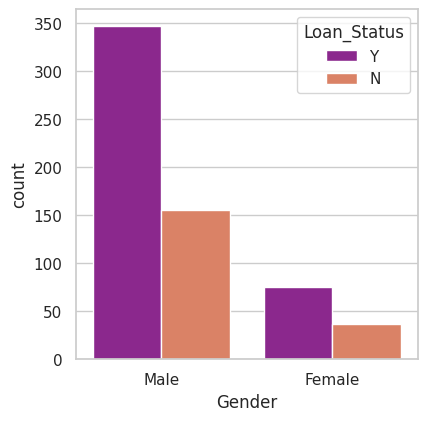

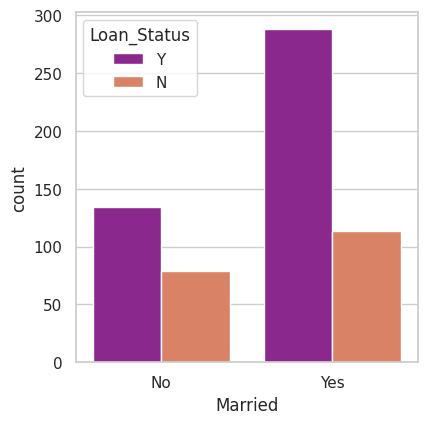

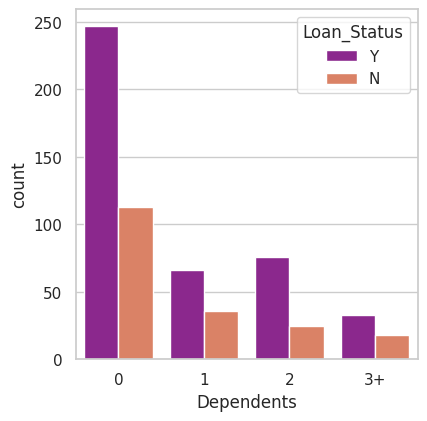

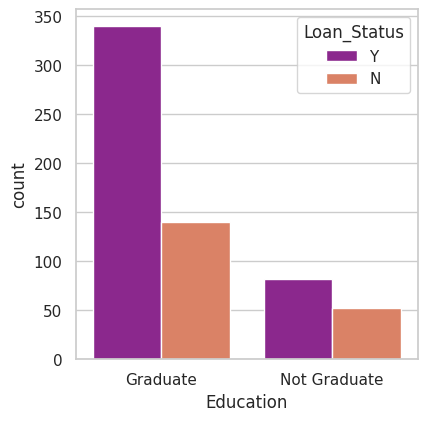

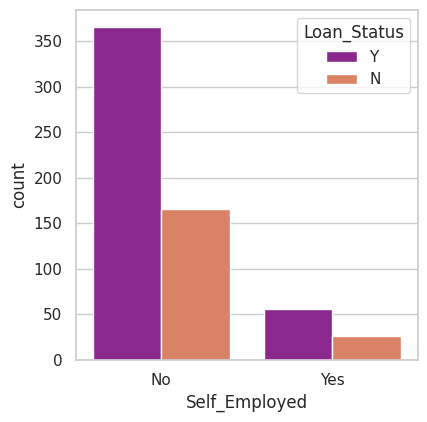

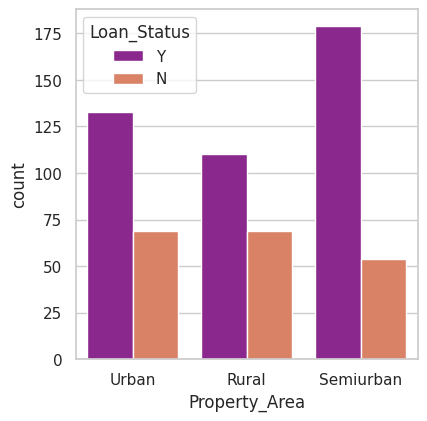

In [40]:
# Visualize categorical columns
for i in cat[:-1]:
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    sns.countplot(x=i,hue='Loan_Status',data=tr_df,palette='plasma')
    plt.xlabel(i,fontsize=12)

## Encoding data to numeric

In [42]:
# convert categorical values to numbers
to_numeric = {
    "Male": 1,
    "Female": 2,
    "Yes": 1,
    "No": 2,
    "Graduate": 1,
    "Not Graduate": 2,
    "Urban": 3,
    "Semiurban": 2,
    "Rural": 1,
    "Y": 1,
    "N": 0,
    "3+": 3,
}
# adding the new numeric values from the to_numeric variable to both datasets
tr_df = tr_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)
te_df=te_df.applymap(lambda label:to_numeric.get(label) if label in to_numeric else label)

# convert the dependents column
Dependents_=pd.to_numeric(tr_df['Dependents'])
Dependents__=pd.to_numeric(te_df['Dependents'])

# drop the previous Dependents column
if 'Dependents' in tr_df.columns.to_list():
    tr_df.drop(['Dependents'],axis=1,inplace=True)
if 'Dependents' in te_df.columns.to_list():
    te_df.drop(['Dependents'],axis=1,inplace=True)
    
# concatenate the new Dependents column with both datasets
tr_df=pd.concat([tr_df,Dependents_],axis=1)
te_df=pd.concat([te_df,Dependents__],axis=1)

# check the dataset for validation
print(f'training set[{tr_df.shape}i], {tr_df.info()}')
print(f'testing set[{te_df.shape}], {te_df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Credit_History     614 non-null    float64
 9   Property_Area      614 non-null    int64  
 10  Loan_Status        614 non-null    int64  
 11  Dependents         614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
training set[(614, 12)i], None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 columns):
 #   Column             Non-Null Cou

## Correlation matrix
To evaluate the relationship between each two categories in dataset

<Axes: >

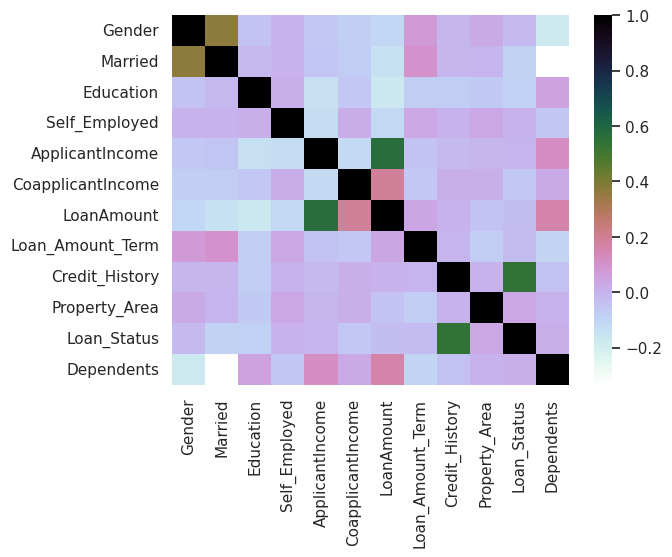

In [43]:
sns.heatmap(tr_df.corr(), cmap='cubehelix_r')

In [52]:
# correlation table
corr=tr_df.corr()
corr.style.background_gradient(cmap='coolwarm').format(lambda x: '{:.2f}'.format(x))

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Dependents
Gender,1.00,0.36,-0.05,-0.00,-0.06,-0.08,-0.11,0.07,-0.01,0.03,-0.02,-0.17
Married,0.36,1.00,-0.01,0.00,-0.05,-0.08,-0.15,0.10,-0.01,-0.00,-0.09,-0.33
Education,-0.05,-0.01,1.00,0.01,-0.14,-0.06,-0.17,-0.07,-0.07,-0.07,-0.09,0.06
Self_Employed,-0.00,0.00,0.01,1.00,-0.13,0.02,-0.11,0.03,0.00,0.03,0.00,-0.06
ApplicantIncome,-0.06,-0.05,-0.14,-0.13,1.00,-0.12,0.56,-0.05,-0.02,-0.01,-0.00,0.12
CoapplicantIncome,-0.08,-0.08,-0.06,0.02,-0.12,1.00,0.19,-0.06,0.01,0.01,-0.06,0.03
LoanAmount,-0.11,-0.15,-0.17,-0.11,0.56,0.19,1.00,0.04,-0.00,-0.05,-0.03,0.16
Loan_Amount_Term,0.07,0.10,-0.07,0.03,-0.05,-0.06,0.04,1.00,-0.00,-0.08,-0.02,-0.10
Credit_History,-0.01,-0.01,-0.07,0.00,-0.02,0.01,-0.00,-0.00,1.00,0.00,0.54,-0.04
Property_Area,0.03,-0.00,-0.07,0.03,-0.01,0.01,-0.05,-0.08,0.00,1.00,0.03,-0.00


`Credit_History` has the highest correlation with `Loan_Status`, use this to
predict target value

## Logistic Regression
Divide dataset into two variables `X` as features  `y` as `Loan_Status` the
target value we want to predict

In [53]:
y=tr_df['Loan_Status']
X=tr_df.drop('Loan_Status',axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [54]:
LR=LogisticRegression()
LR.fit(X_train,y_train)
y_hat=LR.predict(X_test)

# prediction summary by species
print(classification_report(y_test,y_hat))

# accuracy score
LR_SC=accuracy_score(y_hat,y_test)
print('accuracy is',accuracy_score(y_hat,y_test))

              precision    recall  f1-score   support

           0       0.92      0.43      0.59        51
           1       0.82      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.87      0.71      0.74       185
weighted avg       0.85      0.83      0.81       185

accuracy is 0.8324324324324325
